In [46]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg', 'bmp')):
                    self.image_paths.append(os.path.join(subdir, file))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Preprocessing transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CustomImageDataset(root_dir='/yomama', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [47]:
# Define the DDPM model
class SimpleDDPM(nn.Module):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = UNet2DModel(
            sample_size=128,  # Updated to 128x128
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )

    def forward(self, x, t):
        return self.model(x, t).sample

# Initialize the model and scheduler
model = SimpleDDPM().to('cuda')
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Custom Training Function without logging or saving
def train(model, scheduler, criterion, optimizer, dataloader, epochs=100, device='cuda'):
    model.to(device)
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for batch in dataloader:
            images = batch.to(device)
            t = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noise = torch.randn_like(images).to(device)
            noisy_images = scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)

            optimizer.zero_grad()
            predicted_noise = model(noisy_images, t)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

In [48]:
# Train the model
train(model, scheduler, criterion, optimizer, dataloader, epochs=100)

  1%|          | 1/100 [01:37<2:41:03, 97.61s/it]

Epoch 1/100, Loss: 0.02329705304632716


  2%|▏         | 2/100 [03:14<2:38:55, 97.31s/it]

Epoch 2/100, Loss: 0.008137303345531397


  3%|▎         | 3/100 [04:52<2:37:21, 97.34s/it]

Epoch 3/100, Loss: 0.00650893400029267


  4%|▍         | 4/100 [06:28<2:35:13, 97.02s/it]

Epoch 4/100, Loss: 0.005926720988828788


  5%|▌         | 5/100 [08:05<2:33:48, 97.14s/it]

Epoch 5/100, Loss: 0.005538149667435036


  6%|▌         | 6/100 [09:43<2:32:17, 97.21s/it]

Epoch 6/100, Loss: 0.0056152871535437195


  7%|▋         | 7/100 [11:19<2:30:16, 96.95s/it]

Epoch 7/100, Loss: 0.005247132692506093


  8%|▊         | 8/100 [12:56<2:28:30, 96.85s/it]

Epoch 8/100, Loss: 0.005330346283211453


  9%|▉         | 9/100 [14:33<2:27:07, 97.01s/it]

Epoch 9/100, Loss: 0.004932150587405614


 10%|█         | 10/100 [16:10<2:25:37, 97.08s/it]

Epoch 10/100, Loss: 0.004988420161415533


 11%|█         | 11/100 [17:48<2:24:04, 97.13s/it]

Epoch 11/100, Loss: 0.005041034317834438


 12%|█▏        | 12/100 [19:23<2:21:40, 96.59s/it]

Epoch 12/100, Loss: 0.004876580996946154


 13%|█▎        | 13/100 [21:00<2:20:08, 96.65s/it]

Epoch 13/100, Loss: 0.004968548851783098


 14%|█▍        | 14/100 [22:37<2:18:34, 96.68s/it]

Epoch 14/100, Loss: 0.004802464988118883


 15%|█▌        | 15/100 [24:13<2:17:01, 96.72s/it]

Epoch 15/100, Loss: 0.004769187643222005


 16%|█▌        | 16/100 [25:50<2:15:30, 96.79s/it]

Epoch 16/100, Loss: 0.004817155816604611


 17%|█▋        | 17/100 [27:28<2:14:05, 96.94s/it]

Epoch 17/100, Loss: 0.00459710486631822


 18%|█▊        | 18/100 [29:04<2:12:11, 96.73s/it]

Epoch 18/100, Loss: 0.004705318396630394


 18%|█▊        | 18/100 [30:31<2:19:01, 101.73s/it]


KeyboardInterrupt: 

100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


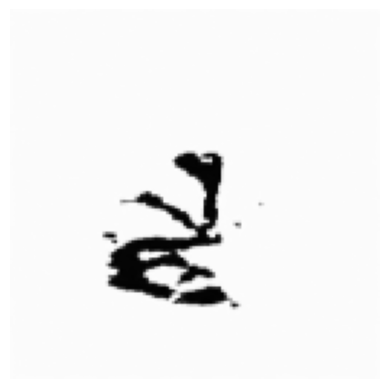

In [49]:
from tqdm import tqdm

# Function to generate images from noise
def generate_images(model, scheduler, num_images=8, device='cuda'):
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(num_images)):
            noise = torch.randn((1, 1, 128, 128)).to(device)
            for t in tqdm(range(scheduler.config.num_train_timesteps - 1, -1, -1)):
                t_tensor = torch.tensor([t], device=device).long()
                predicted_noise = model(noise, t_tensor)
                noise = scheduler.step(model_output=predicted_noise, timestep=t_tensor, sample=noise).prev_sample
            plt.subplot(1, num_images, i + 1)
            plt.imshow(noise.squeeze().cpu().numpy(), cmap='gray')
            plt.axis('off')
    plt.show()

# Generate and display images
generate_images(model, scheduler, num_images=1)

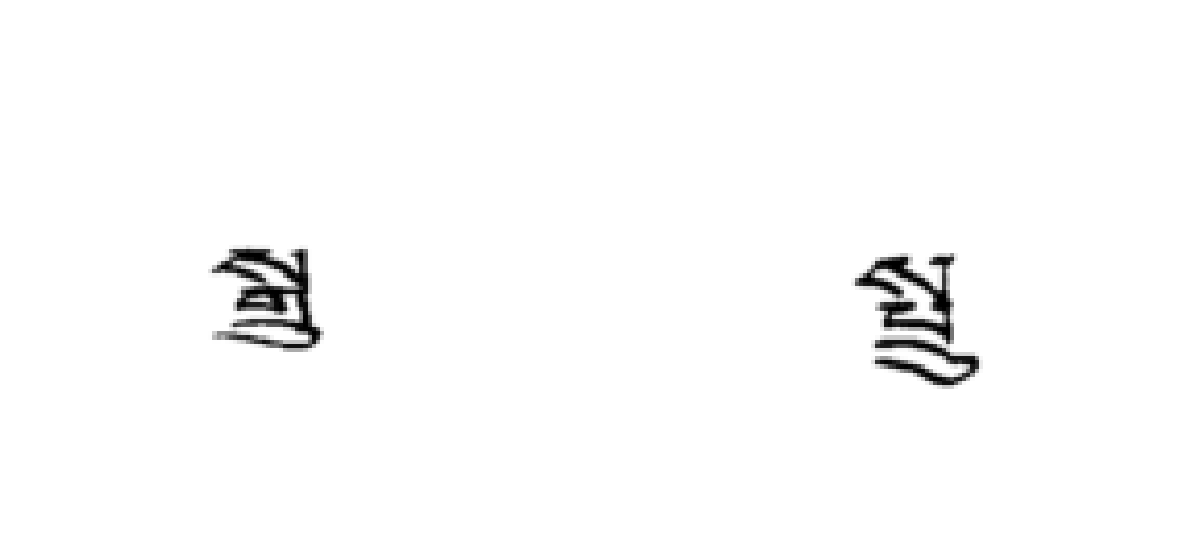

In [31]:
import matplotlib.pyplot as plt

# Function to visualize a few images from the dataset
def visualize_dataset(dataset, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        image = (image * 0.5 + 0.5)  # Denormalize
        axs[i].imshow(image, cmap='gray')
        axs[i].axis('off')
    plt.show()

# Visualize a few images from the dataset
visualize_dataset(dataset, num_images=2)
